In [ ]:
What is RAGAs
RAGAs (Retrieval-Augmented Generation Assessment) is a framework (GitHub, Docs) that provides you with the necessary ingredients to help you evaluate your RAG pipeline on a component level.



What is RAGAs?


RAGAs (Retrieval-Augmented Generation Assessment) is a framework (GitHub, Docs) that provides you with the necessary ingredients to help you evaluate your RAG pipeline on a component level.



Evaluation Data
What’s interesting about RAGAs is that it started out as a framework for “reference-free” evaluation [1]. That means, instead of having to rely on human-annotated ground truth labels in the evaluation dataset, RAGAs leverages LLMs under the hood to conduct the evaluations.

To evaluate the RAG pipeline, RAGAs expects the following information:

question: The user query that is the input of the RAG pipeline. The input.
answer: The generated answer from the RAG pipeline. The output.
contexts: The contexts retrieved from the external knowledge source used to answer the question.
ground_truths: The ground truth answer to the question. This is the only human-annotated information. This information is only required for the metric context_recall (see Evaluation Metrics).
Leveraging LLMs for reference-free evaluation is an active research topic. While using as little human-annotated data as possible makes it a cheaper and faster evaluation method, there is still some discussion about its shortcomings, such as bias [3]. However, some papers have already shown promising results [4]. For detailed information, see the “Related Work” section of the RAGAs [1] paper.

Note that the framework has expanded to provide metrics and paradigms that require ground truth labels (e.g., context_recall and answer_correctness, see Evaluation Metrics).

Additionally, the framework provides you with tooling for automatic test data generation.

Evaluation Metrics
RAGAs provide you with a few metrics to evaluate a RAG pipeline component-wise as well as end-to-end.

On a component level, RAGAs provides you with metrics to evaluate the retrieval component (context_relevancy and context_recall) and the generative component (faithfulness and answer_relevancy) separately [2]:

Context precision measures the signal-to-noise ratio of the retrieved context. This metric is computed using the question and the contexts.
Context recall measures if all the relevant information required to answer the question was retrieved. This metric is computed based on the ground_truth (this is the only metric in the framework that relies on human-annotated ground truth labels) and the contexts.
Faithfulness measures the factual accuracy of the generated answer. The number of correct statements from the given contexts is divided by the total number of statements in the generated answer. This metric uses the question, contextsand the answer.
Answer relevancy measures how relevant the generated answer is to the question. This metric is computed using the question and the answer. For example, the answer “France is in western Europe.” to the question “Where is France and what is it’s capital?” would achieve a low answer relevancy because it only answers half of the question.
All metrics are scaled to the range [0, 1], with higher values indicating a better performance.

RAGAs also provides you with metrics to evaluate the RAG pipeline end-to-end, such as answer semantic similarity and answer correctness. This article focuses on the component-level metrics.

Evaluating a RAG Application with RAGAs
This section uses RAGAs to evaluate a minimal vanilla RAG pipeline to show you how to use RAGAs and to give you an intuition about its evaluation metrics.

In [ ]:
#!pip install langchain openai weaviate-client ragas


Additionally, define your relevant environment variables in a .env file in your root directory. To obtain an OpenAI API Key, you need an OpenAI account and then “Create new secret key” under API keys.



In [ ]:
OPENAI_API_KEY="<YOUR_OPENAI_API_KEY>"


Setting up the RAG application
Before you can evaluate your RAG application, you need to set it up. We will use a vanilla RAG pipeline. We will keep this section short since we will use the same setup described in detail in the following article.

First, you must prepare the data by loading and chunking the documents.



In [ ]:
import requests
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

url = "https://raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/modules/state_of_the_union.txt"
res = requests.get(url)
with open("state_of_the_union.txt", "w") as f:
    f.write(res.text)

# Load the data
loader = TextLoader('./state_of_the_union.txt')
documents = loader.load()

# Chunk the data
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(documents)

Next, generate the vector embeddings for each chunk with the OpenAI embedding model and store them in the vector database.



In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Weaviate
import weaviate
from weaviate.embedded import EmbeddedOptions
from dotenv import load_dotenv,find_dotenv

# Load OpenAI API key from .env file
load_dotenv(find_dotenv())

# Setup vector database
client = weaviate.Client(
  embedded_options = EmbeddedOptions()
)

# Populate vector database
vectorstore = Weaviate.from_documents(
    client = client,
    documents = chunks,
    embedding = OpenAIEmbeddings(),
    by_text = False
)

# Define vectorstore as retriever to enable semantic search
retriever = vectorstore.as_retriever()

Finally, set up a prompt template and the OpenAI LLM and combine them with the retriever component to a RAG pipeline.



In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Define LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Define prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use two sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

# Setup RAG pipeline
rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

Preparing the Evaluation Data
As RAGAs aims to be a reference-free evaluation framework, the required preparations of the evaluation dataset are minimal. You will need to prepare question and ground_truths pairs from which you can prepare the remaining information through inference as follows:



In [ ]:
from datasets import Dataset

questions = ["What did the president say about Justice Breyer?",
             "What did the president say about Intel's CEO?",
             "What did the president say about gun violence?",
            ]
ground_truths = [["The president said that Justice Breyer has dedicated his life to serve the country and thanked him for his service."],
                ["The president said that Pat Gelsinger is ready to increase Intel's investment to $100 billion."],
                ["The president asked Congress to pass proven measures to reduce gun violence."]]
answers = []
contexts = []

# Inference
for query in questions:
  answers.append(rag_chain.invoke(query))
  contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

If you are not interested in the context_recall metric, you don’t need to provide the ground_truths information. In this case, all you need to prepare are the questions.

Evaluating the RAG application
First, import all the metrics you want to use from ragas.metrics. Then, you can use the evaluate() function and simply pass in the relevant metrics and the prepared dataset.

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

df = result.to_pandas()

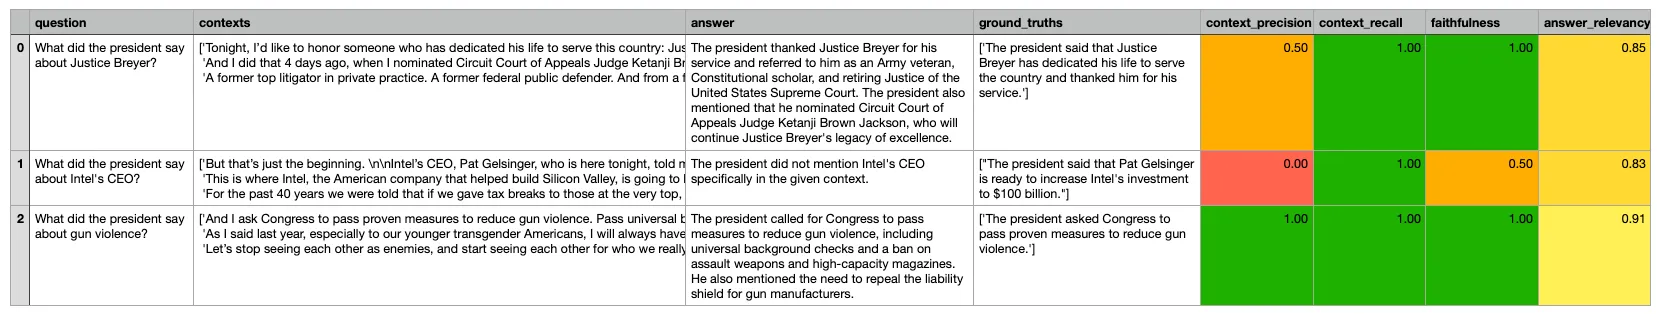

We can make the following observations:

context_relevancy (signal-to-noise ratio of the retrieved context): While the LLM judges all of the context as relevant for the last question, it also judges that most of the retrieved context for the second question is irrelevant. Depending on this metric, you could experiment with different numbers of retrieved contexts to reduce the noise.
context_recall (if all the relevant information required to answer the question was retrieved): The LLMs evaluate that the retrieved contexts contain the relevant information required to answer the questions correctly.
faithfulness (factual accuracy of the generated answer): While the LLM judges that the first and last questions are answered correctly, the answer to the second question, which wrongly states that the president did not mention Intel’s CEO, is judged with a faithfulness of 0.5.
answer_relevancy (how relevant is the generated answer to the question): All of the generated answers are judged as fairly relevant to the questions.
As mentioned in Evaluation Data, using LLMs for reference-free evaluation is an active research field. I am curious to see how this topic will evolve.



Summary
Building a proof-of-concept RAG application is easy, but getting its performance production-ready is hard. Like a machine learning project, you should evaluate the RAG pipeline’s performance with a validation dataset and an evaluation metric.

However, since a RAG pipeline consists of multiple components that must be evaluated separately and in combinations, you will require a set of evaluation metrics. Additionally, generating a high-quality validation dataset from human annotators is hard, time-consuming, and expensive.

This article has introduced the RAGAs [1] evaluation framework. The framework proposes four evaluation metrics — context_relevancy, context_recall, faithfulness and answer_relevancy — that together make up the RAGAs score. Additionally, RAGAs leverages LLMs under the hood for reference-free evaluation to save costs.

Now that you have the tools to evaluate your RAG application’s performance, I recommend setting up an experimentation pipeline and start tweaking the performance with the following tuning strategies:

